In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2008",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2008",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2008",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

100%|████████████████████████████████████| 577034240/577034240 [28:14<00:00, 340529.98it/s]


Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2012.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2012.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
#Training Samples: 511
#Validation Samples: 1023
#Testing Samples: 512
#Training Batch: 16
#Validation Batch: 32
#Testing Batch: 16


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


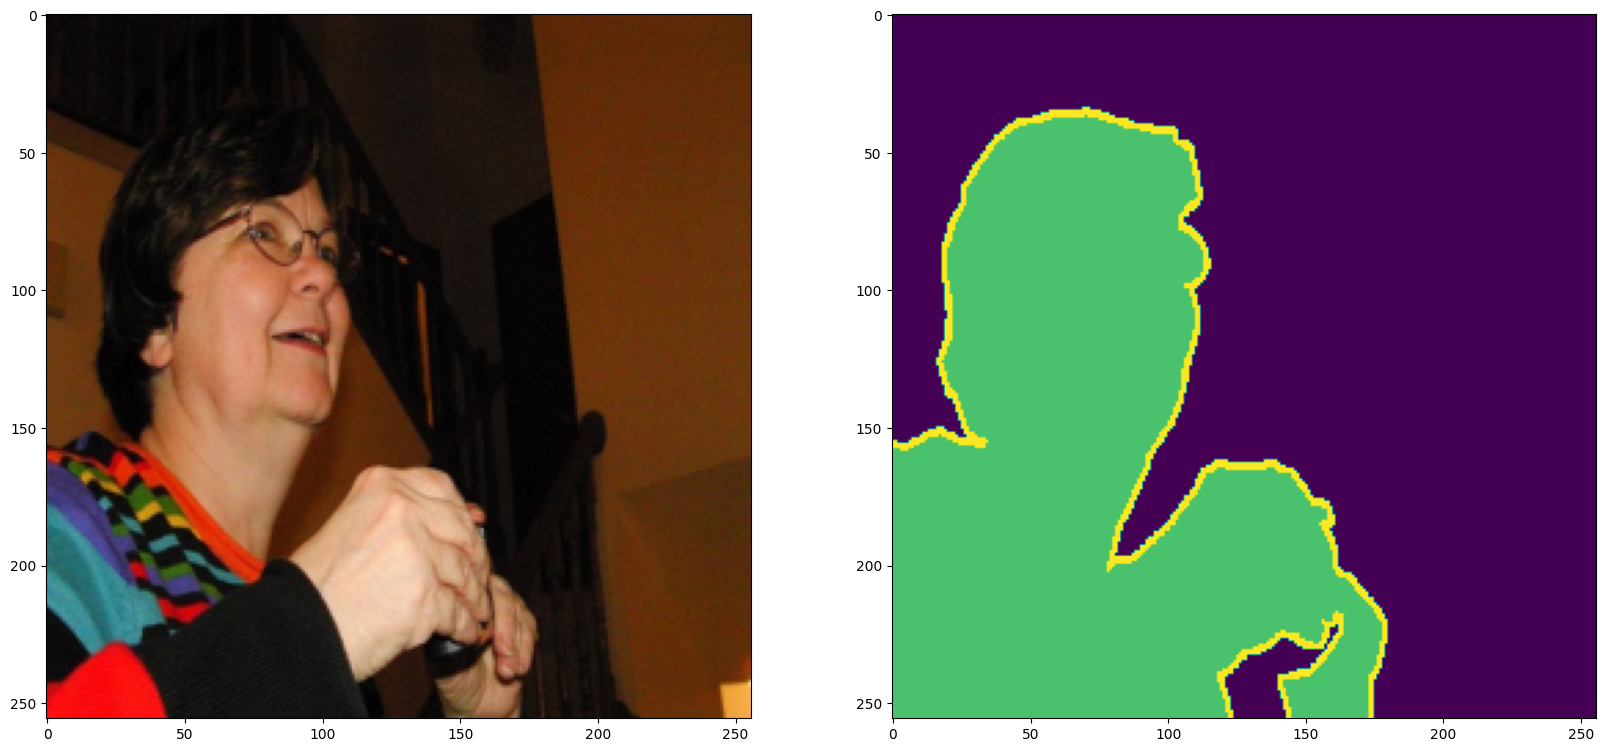

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.78it/s]


Epoch: 0 - TrainLoss: 3.875201553106308 - ValidLoss: 7.268921375274658


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.97it/s]


Epoch: 1 - TrainLoss: 3.478165179491043 - ValidLoss: 6.808036804199219


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch: 2 - TrainLoss: 3.191584125161171 - ValidLoss: 6.069252967834473


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.27it/s]


Epoch: 3 - TrainLoss: 2.875672161579132 - ValidLoss: 5.353609085083008


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.29it/s]


Epoch: 4 - TrainLoss: 2.5651923567056656 - ValidLoss: 4.954361438751221


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.16it/s]


Epoch: 5 - TrainLoss: 2.296006590127945 - ValidLoss: 4.7548980712890625


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.96it/s]


Epoch: 6 - TrainLoss: 2.070882126688957 - ValidLoss: 4.00126838684082


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.09it/s]


Epoch: 7 - TrainLoss: 1.892575204372406 - ValidLoss: 3.532745361328125


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.23it/s]


Epoch: 8 - TrainLoss: 1.7871447205543518 - ValidLoss: 3.2639522552490234


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.76it/s]


Epoch: 9 - TrainLoss: 1.7210844829678535 - ValidLoss: 3.9192097187042236


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.05it/s]


Epoch: 10 - TrainLoss: 1.685059867799282 - ValidLoss: 3.52677059173584


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.16it/s]


Epoch: 11 - TrainLoss: 1.6486739739775658 - ValidLoss: 3.6288347244262695


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.29it/s]


Epoch: 12 - TrainLoss: 1.6285479664802551 - ValidLoss: 3.676974296569824


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.00it/s]


Epoch: 13 - TrainLoss: 1.6194676831364632 - ValidLoss: 2.5931835174560547


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch: 14 - TrainLoss: 1.6100378707051277 - ValidLoss: 2.9011385440826416


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.29it/s]


Epoch: 15 - TrainLoss: 1.5926804393529892 - ValidLoss: 2.957973003387451


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.04it/s]


Epoch: 16 - TrainLoss: 1.5798053294420242 - ValidLoss: 3.0304503440856934


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.15it/s]


Epoch: 17 - TrainLoss: 1.5671684741973877 - ValidLoss: 2.868368625640869


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.06it/s]


Epoch: 18 - TrainLoss: 1.5477374568581581 - ValidLoss: 3.2606334686279297


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch: 19 - TrainLoss: 1.5323839262127876 - ValidLoss: 2.6365456581115723


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.03it/s]


Epoch: 20 - TrainLoss: 1.5098723471164703 - ValidLoss: 2.919891119003296


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.33it/s]


Epoch: 21 - TrainLoss: 1.5059704035520554 - ValidLoss: 2.77388334274292


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.18it/s]


Epoch: 22 - TrainLoss: 1.4950243085622787 - ValidLoss: 2.7526445388793945


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.00it/s]


Epoch: 23 - TrainLoss: 1.47855244576931 - ValidLoss: 2.5770678520202637


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch: 24 - TrainLoss: 1.4632024988532066 - ValidLoss: 3.43503475189209


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.04it/s]


Epoch: 25 - TrainLoss: 1.454438790678978 - ValidLoss: 3.2335846424102783


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.05it/s]


Epoch: 26 - TrainLoss: 1.4675244241952896 - ValidLoss: 2.9426565170288086


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.05it/s]


Epoch: 27 - TrainLoss: 1.4566860124468803 - ValidLoss: 2.3108067512512207


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.16it/s]


Epoch: 28 - TrainLoss: 1.4458853974938393 - ValidLoss: 2.7506346702575684


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.87it/s]


Epoch: 29 - TrainLoss: 1.4198273718357086 - ValidLoss: 2.636671304702759


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.23it/s]


Epoch: 30 - TrainLoss: 1.398528017103672 - ValidLoss: 3.239535331726074


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.11it/s]


Epoch: 31 - TrainLoss: 1.3795045018196106 - ValidLoss: 2.7041172981262207


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.36it/s]


Epoch: 32 - TrainLoss: 1.3872403651475906 - ValidLoss: 2.998474597930908


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch: 33 - TrainLoss: 1.3666801378130913 - ValidLoss: 3.105400562286377


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.11it/s]


Epoch: 34 - TrainLoss: 1.351292259991169 - ValidLoss: 2.7575652599334717


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch: 35 - TrainLoss: 1.3509525060653687 - ValidLoss: 3.1695897579193115


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch: 36 - TrainLoss: 1.3163467943668365 - ValidLoss: 2.3228776454925537


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.15it/s]


Epoch: 37 - TrainLoss: 1.3186409175395966 - ValidLoss: 2.050513982772827


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.08it/s]


Epoch: 38 - TrainLoss: 1.3054658398032188 - ValidLoss: 2.7488298416137695


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.17it/s]


Epoch: 39 - TrainLoss: 1.297129776328802 - ValidLoss: 2.4375762939453125


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.99it/s]


Epoch: 40 - TrainLoss: 1.293114311993122 - ValidLoss: 3.277437925338745


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch: 41 - TrainLoss: 1.2859646826982498 - ValidLoss: 2.9221415519714355


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.16it/s]


Epoch: 42 - TrainLoss: 1.2621273919939995 - ValidLoss: 2.714742660522461


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.06it/s]


Epoch: 43 - TrainLoss: 1.2469770312309265 - ValidLoss: 2.5128774642944336


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch: 44 - TrainLoss: 1.2228062599897385 - ValidLoss: 2.45688533782959


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.78it/s]


Epoch: 45 - TrainLoss: 1.1992042437195778 - ValidLoss: 2.2853736877441406


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.06it/s]


Epoch: 46 - TrainLoss: 1.1851294189691544 - ValidLoss: 2.5244088172912598


100%|██████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


Epoch: 47 - TrainLoss: 1.1774023100733757 - ValidLoss: 2.0301289558410645


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.56it/s]


Epoch: 48 - TrainLoss: 1.1845547184348106 - ValidLoss: 2.1778693199157715


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.63it/s]


Epoch: 49 - TrainLoss: 1.1660683788359165 - ValidLoss: 2.237399101257324


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.03it/s]


Epoch: 50 - TrainLoss: 1.1534304730594158 - ValidLoss: 2.577561616897583


100%|██████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.52it/s]


Epoch: 51 - TrainLoss: 1.1448007375001907 - ValidLoss: 2.1638054847717285


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.23it/s]


Epoch: 52 - TrainLoss: 1.112060371786356 - ValidLoss: 2.158599853515625


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.70it/s]


Epoch: 53 - TrainLoss: 1.0996163189411163 - ValidLoss: 2.279430627822876


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.07it/s]


Epoch: 54 - TrainLoss: 1.0873457714915276 - ValidLoss: 1.9435430765151978


100%|██████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.39it/s]


Epoch: 55 - TrainLoss: 1.0611624158918858 - ValidLoss: 2.0239620208740234


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.95it/s]


Epoch: 56 - TrainLoss: 1.047677006572485 - ValidLoss: 1.8918787240982056


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.29it/s]


Epoch: 57 - TrainLoss: 1.0422948747873306 - ValidLoss: 2.3203654289245605


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.87it/s]


Epoch: 58 - TrainLoss: 1.0283471792936325 - ValidLoss: 2.5089235305786133


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.36it/s]


Epoch: 59 - TrainLoss: 1.0160290449857712 - ValidLoss: 1.9682449102401733


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.07it/s]


Epoch: 60 - TrainLoss: 0.9934253096580505 - ValidLoss: 2.0325756072998047


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.42it/s]


Epoch: 61 - TrainLoss: 0.9905176684260368 - ValidLoss: 2.1173248291015625


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.92it/s]


Epoch: 62 - TrainLoss: 0.9542101956903934 - ValidLoss: 1.8041818141937256


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.71it/s]


Epoch: 63 - TrainLoss: 0.9331782199442387 - ValidLoss: 1.8576757907867432


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.88it/s]


Epoch: 64 - TrainLoss: 0.9426493123173714 - ValidLoss: 1.6717171669006348


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.56it/s]


Epoch: 65 - TrainLoss: 0.9173703528940678 - ValidLoss: 1.5558804273605347


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


Epoch: 66 - TrainLoss: 0.9090588875114918 - ValidLoss: 1.9770143032073975


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.59it/s]


Epoch: 67 - TrainLoss: 0.9092055410146713 - ValidLoss: 1.8917838335037231


100%|██████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.70it/s]


Epoch: 68 - TrainLoss: 0.8682150766253471 - ValidLoss: 1.956818699836731


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.15it/s]


Epoch: 69 - TrainLoss: 0.8678172305226326 - ValidLoss: 1.4408197402954102


100%|██████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.38it/s]


Epoch: 70 - TrainLoss: 0.8392666019499302 - ValidLoss: 1.7034913301467896


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.95it/s]


Epoch: 71 - TrainLoss: 0.8125653527677059 - ValidLoss: 1.7446141242980957


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.36it/s]


Epoch: 72 - TrainLoss: 0.8167912736535072 - ValidLoss: 1.8715693950653076


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.70it/s]


Epoch: 73 - TrainLoss: 0.8152201995253563 - ValidLoss: 1.463380217552185


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.02it/s]


Epoch: 74 - TrainLoss: 0.7960444241762161 - ValidLoss: 1.653061032295227


100%|██████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch: 75 - TrainLoss: 0.7853394187986851 - ValidLoss: 1.409898042678833


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.01it/s]


Epoch: 76 - TrainLoss: 0.7861432731151581 - ValidLoss: 1.6653587818145752


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.71it/s]


Epoch: 77 - TrainLoss: 0.7714828439056873 - ValidLoss: 1.6952366828918457


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.71it/s]


Epoch: 78 - TrainLoss: 0.7624542266130447 - ValidLoss: 1.4232505559921265


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s]


Epoch: 79 - TrainLoss: 0.7432173490524292 - ValidLoss: 1.2681087255477905


100%|██████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.46it/s]


Epoch: 80 - TrainLoss: 0.7422221526503563 - ValidLoss: 1.7156513929367065


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.18it/s]


Epoch: 81 - TrainLoss: 0.7266646772623062 - ValidLoss: 1.5765146017074585


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.67it/s]


Epoch: 82 - TrainLoss: 0.7110473476350307 - ValidLoss: 1.3478820323944092


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.20it/s]


Epoch: 83 - TrainLoss: 0.7190018780529499 - ValidLoss: 1.2408262491226196


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.88it/s]


Epoch: 84 - TrainLoss: 0.7165347188711166 - ValidLoss: 1.5837855339050293


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.36it/s]


Epoch: 85 - TrainLoss: 0.7159717753529549 - ValidLoss: 1.263460397720337


100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.28it/s]


Epoch: 86 - TrainLoss: 0.7049711979925632 - ValidLoss: 1.4316681623458862


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.57it/s]


Epoch: 87 - TrainLoss: 0.7030751332640648 - ValidLoss: 1.5070239305496216


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.84it/s]


Epoch: 88 - TrainLoss: 0.6994664818048477 - ValidLoss: 1.7330448627471924


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.06it/s]


Epoch: 89 - TrainLoss: 0.6787304133176804 - ValidLoss: 1.3788292407989502


100%|██████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]


Epoch: 90 - TrainLoss: 0.7137620523571968 - ValidLoss: 1.423585295677185


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.84it/s]


Epoch: 91 - TrainLoss: 0.6938214674592018 - ValidLoss: 1.2481186389923096


100%|██████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.17it/s]


Epoch: 92 - TrainLoss: 0.6889571100473404 - ValidLoss: 1.3122096061706543


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.96it/s]


Epoch: 93 - TrainLoss: 0.6865496411919594 - ValidLoss: 1.2620700597763062


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.56it/s]


Epoch: 94 - TrainLoss: 0.7015510275959969 - ValidLoss: 1.271139144897461


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.56it/s]


Epoch: 95 - TrainLoss: 0.6864469461143017 - ValidLoss: 1.4877700805664062


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch: 96 - TrainLoss: 0.6819823607802391 - ValidLoss: 1.143925428390503


100%|██████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.58it/s]


Epoch: 97 - TrainLoss: 0.6793503947556019 - ValidLoss: 1.4479846954345703


100%|██████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.72it/s]


Epoch: 98 - TrainLoss: 0.687985748052597 - ValidLoss: 1.3486409187316895


100%|██████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.45it/s]

Epoch: 99 - TrainLoss: 0.691599078476429 - ValidLoss: 1.256980538368225


<All keys matched successfully>

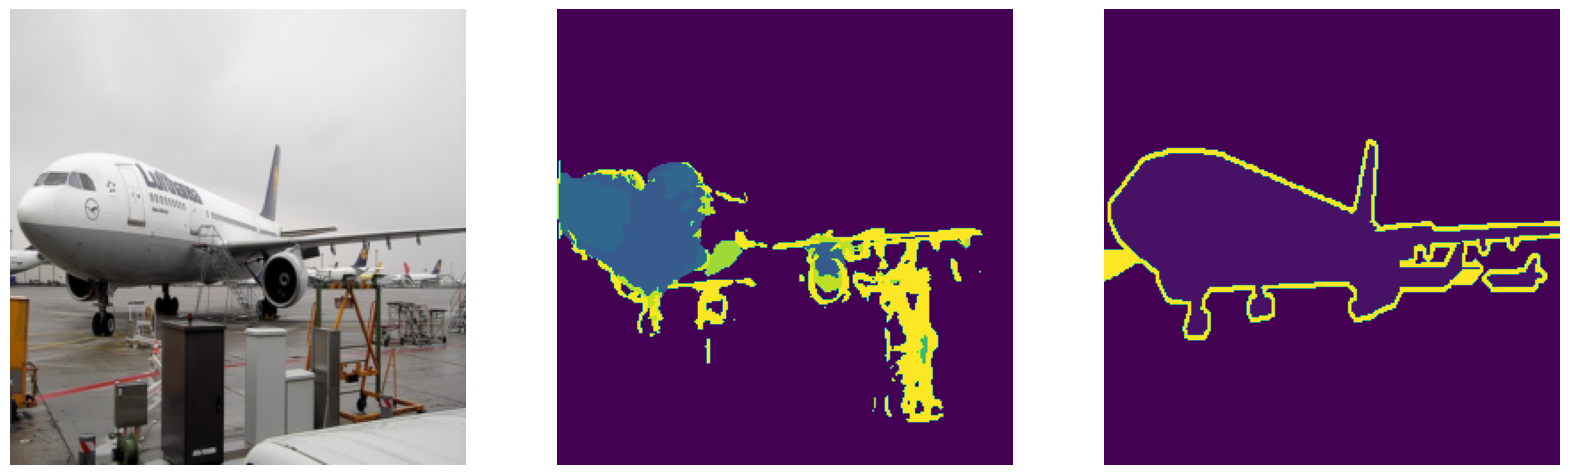

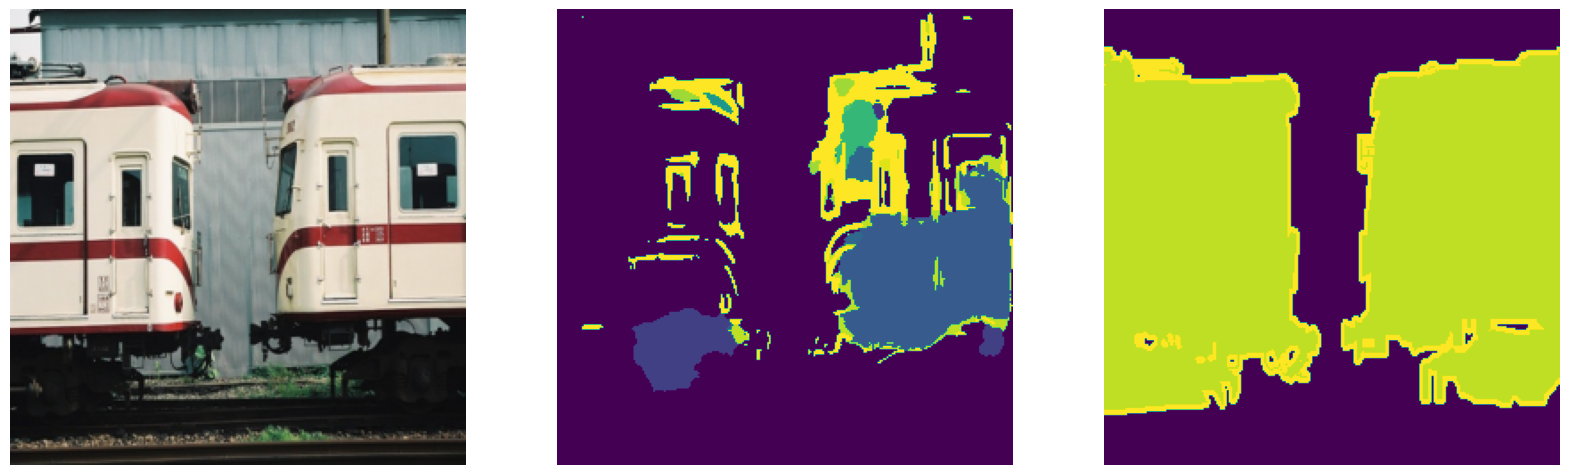

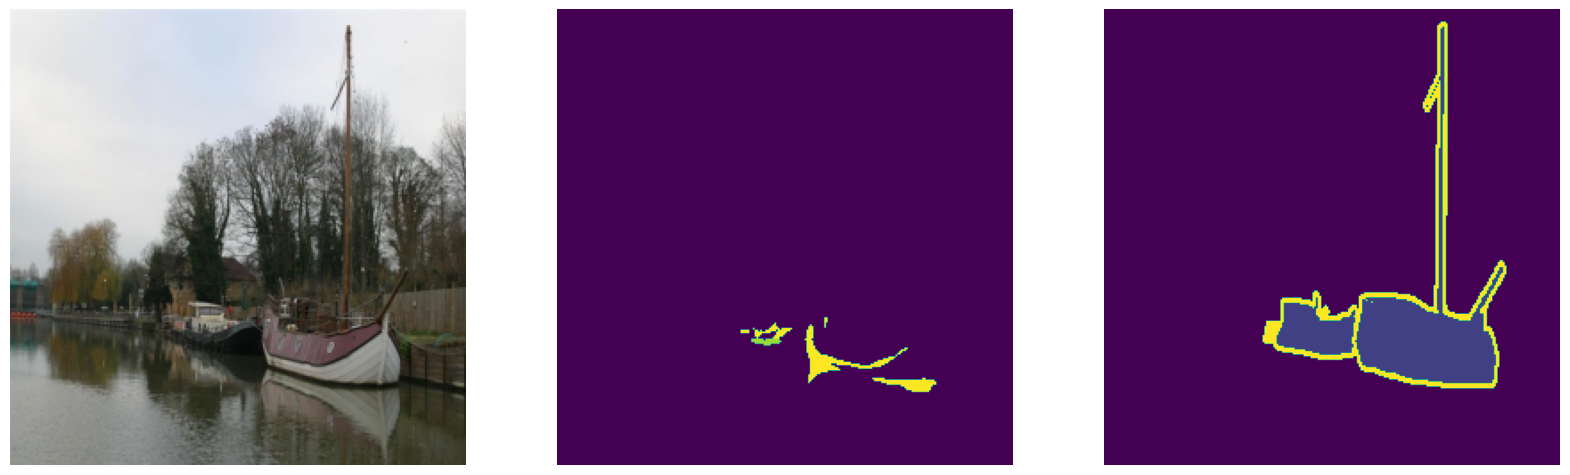

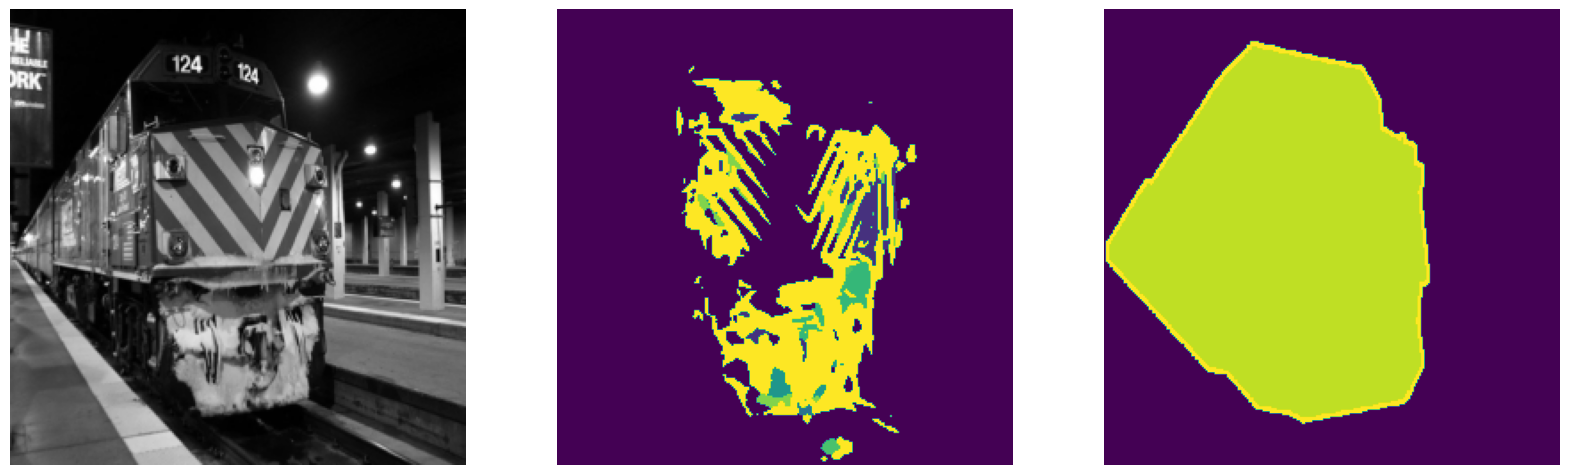

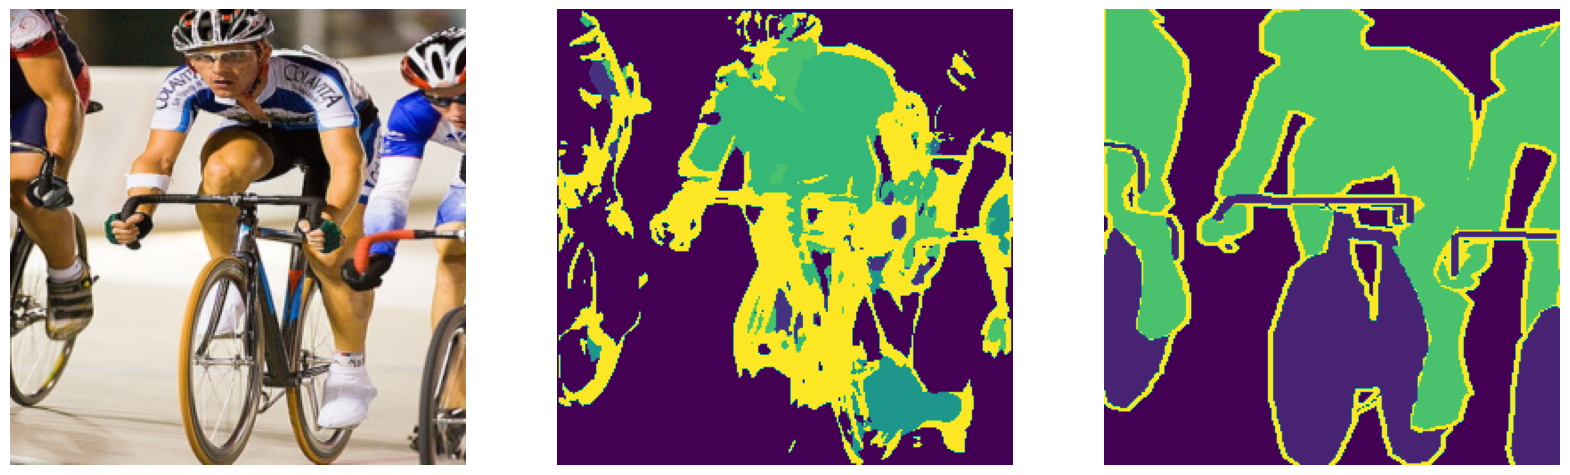

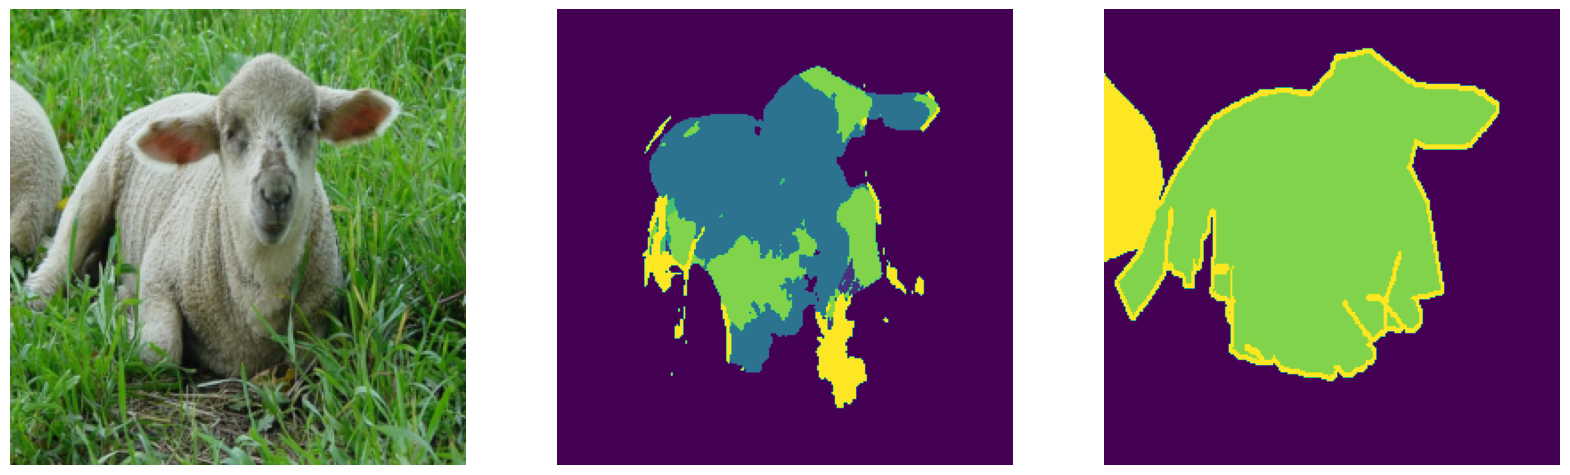

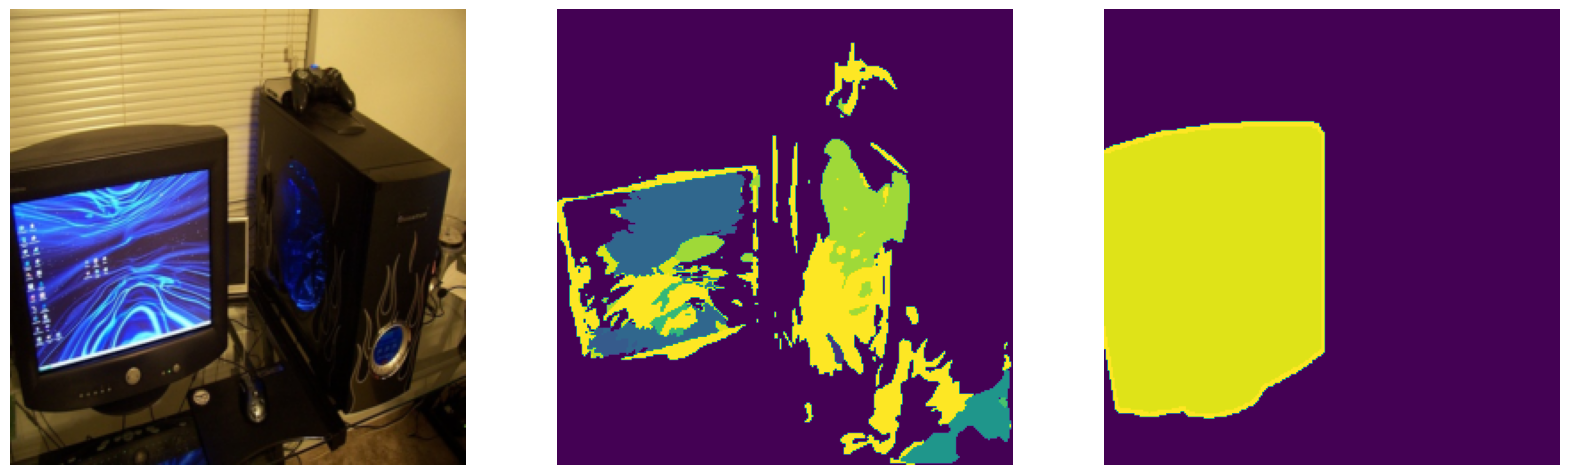

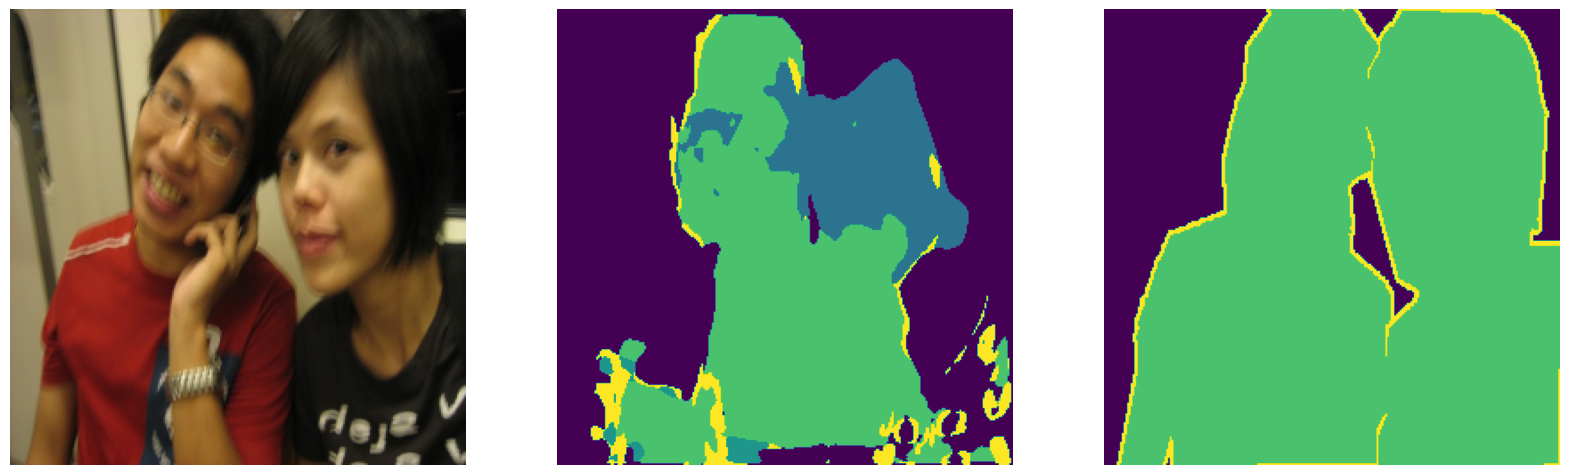

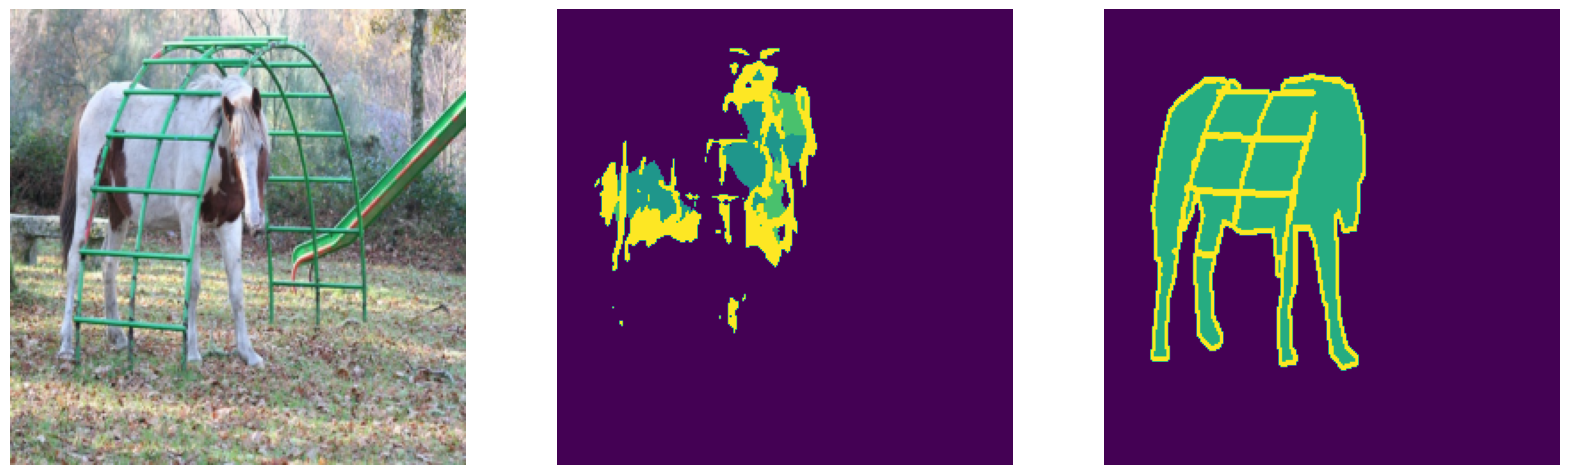

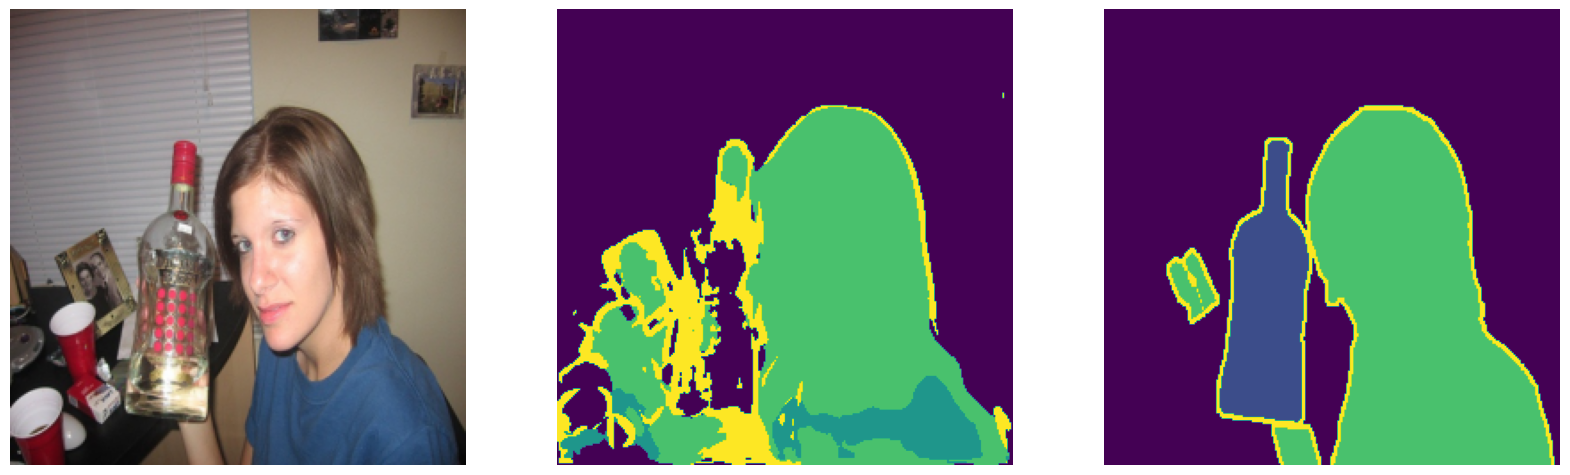

In [12]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')